# PCC142 - Mineração de Dados
## Estimando o desempenho de classificadores
### Aluno: Gabriel F. Costa

Considerando o conjunto de dados de treinamento do desafio "Spaceship Titanic" do Kaggle (https://www.kaggle.com/competitions/spaceship-titanic) e usando Jupyter Notebook ou Google Colab, faça:

* Usando duas técnicas de indução de classificadores, obtenha classificadores e estime o seu desempenho usando validação cruzada com 10 folds.

Use a técnica de Grid Search para encontrar os melhores valores de parâmetros para as técnicas utilizadas.

Como resultado final, para cada classificador, apresente os melhores valores de parâmetros, a média e o desvio padrão das acurácias.

Faça o upload do arquivo Python Notebook da implementação acima.

# Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Obtendo os dados

In [ ]:
!git clone https://github.com/gabrielxcosta/PCC142---Data-Mining.git

fatal: destination path 'PCC142---Data-Mining' already exists and is not an empty directory.


# Classe p/ resolução do problema

In [ ]:
class TitanicClassifierEvaluator:
    """
    Class to load, preprocess, train, evaluate, and visualize classifiers
    for the Spaceship Titanic Kaggle dataset.

    This class handles:
    - Loading train, test, and sample submission data from a zip archive.
    - Preparing feature matrices and target vectors.
    - Creating preprocessing pipelines for numeric and categorical features.
    - Performing hyperparameter tuning with GridSearchCV.
    - Evaluating classifiers using stratified k-fold cross-validation.
    - Storing and summarizing results.
    - Plotting boxplots of cross-validation accuracy scores.

    Attributes:
        zip_path (str): Path to the zip file containing the dataset CSV files.
        df_train (pd.DataFrame): Training dataset.
        df_test (pd.DataFrame): Test dataset.
        df_submission (pd.DataFrame): Sample submission data.
        X (pd.DataFrame): Feature matrix for training.
        y (pd.Series): Target vector for training.
        num_cols (list): List of numeric feature column names.
        cat_cols (list): List of categorical feature column names.
        preprocessor (ColumnTransformer): Combined preprocessing pipeline.
        cv (StratifiedKFold): Stratified k-fold cross-validator.
        results (dict): Stores evaluation metrics and best estimators per classifier.

    Methods:
        load_data():
            Loads train.csv, test.csv, and sample_submission.csv from the zip archive,
            prepares feature matrix X and target vector y for training.

        prepare_pipeline():
            Defines preprocessing pipelines for numeric and categorical features,
            including imputation and scaling/encoding.

        evaluate_classifier(name, classifier, param_grid):
            Performs hyperparameter tuning and cross-validation for a classifier,
            stores the best parameters and accuracy statistics.

        plot_boxplot_results():
            Creates a boxplot visualizing the distribution of accuracy scores
            from cross-validation for all evaluated classifiers.
    """

    def __init__(self, zip_path):
        self.zip_path = zip_path
        self.df_train = None
        self.df_test = None
        self.df_submission = None
        self.X = None
        self.y = None
        self.num_cols = []
        self.cat_cols = []
        self.preprocessor = None
        # Stratified K-Fold cross-validation with 10 splits and fixed random seed
        self.cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        self.results = {}

    def load_data(self):
        """
        Loads train.csv, test.csv, and sample_submission.csv from the zip archive.
        Extracts features (X) and target variable (y) from the training data,
        dropping non-informative or identifier columns.
        """
        with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
            # Read train data into DataFrame
            with zip_ref.open('train.csv') as train_file:
                self.df_train = pd.read_csv(train_file)
            # Read test data into DataFrame
            with zip_ref.open('test.csv') as test_file:
                self.df_test = pd.read_csv(test_file)
            # Read sample submission into DataFrame
            with zip_ref.open('sample_submission.csv') as sub_file:
                self.df_submission = pd.read_csv(sub_file)

        df = self.df_train.copy()
        # Drop target and identifier columns from features
        self.X = df.drop(columns=['Transported', 'PassengerId', 'Name', 'Cabin'])
        # Target variable
        self.y = df['Transported']

    def prepare_pipeline(self):
        """
        Identifies numeric and categorical columns in the feature matrix X.
        Creates separate preprocessing pipelines for numeric (imputation + scaling)
        and categorical (imputation + one-hot encoding) data.
        Combines these into a ColumnTransformer to be applied before classification.
        """
        # Select numeric columns (int and float)
        self.num_cols = self.X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        # Select categorical columns (object and bool)
        self.cat_cols = self.X.select_dtypes(include=['object', 'bool']).columns.tolist()

        # Numeric pipeline: fill missing with median, then standardize features
        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        # Categorical pipeline: fill missing with most frequent, then one-hot encode
        cat_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # Combine numeric and categorical pipelines
        self.preprocessor = ColumnTransformer([
            ('num', num_pipeline, self.num_cols),
            ('cat', cat_pipeline, self.cat_cols)
        ])

    def evaluate_classifier(self, name, classifier, param_grid):
        """
        Performs hyperparameter tuning on the given classifier using GridSearchCV
        with stratified k-fold cross-validation. Evaluates the best estimator
        with cross_val_score and stores the results for later analysis.

        Args:
            name (str): Name to identify the classifier.
            classifier (sklearn estimator): Classifier instance to train.
            param_grid (dict): Dictionary of hyperparameters for GridSearchCV.
        """
        print(f"\nTraining {name} with GridSearchCV...")
        # Build pipeline: preprocessing + classifier
        pipe = Pipeline([
            ('preproc', self.preprocessor),
            ('clf', classifier)
        ])
        # Perform exhaustive grid search with CV to find best hyperparameters
        grid = GridSearchCV(pipe, param_grid, cv=self.cv, scoring='accuracy', n_jobs=-1, verbose=1)
        grid.fit(self.X, self.y)

        # Extract best model from grid search
        best_model = grid.best_estimator_
        # Evaluate the best model using cross-validation scores
        scores = cross_val_score(best_model, self.X, self.y, cv=self.cv, scoring='accuracy', n_jobs=-1)

        # Save results for summary and visualization
        self.results[name] = {
            'best_params': grid.best_params_,
            'cv_mean': scores.mean(),
            'cv_std': scores.std(),
            # Store classifier instance (needed for boxplot evaluation)
            'clf_instance': grid.best_estimator_.named_steps['clf']
        }

        # Print best hyperparameters and cross-validation accuracy results
        print(f"Best params for {name}: {grid.best_params_}")
        print(f"Mean Accuracy: {scores.mean():.4f}")
        print(f"Std Deviation: {scores.std():.4f}")

    def plot_boxplot_results(self):
        """
        Aggregates accuracy scores from cross-validation for all evaluated classifiers,
        then creates and displays a boxplot comparing their accuracy distributions.
        Annotates the plot with mean accuracy values for clarity.
        Saves the plot as 'fig_boxplot.pdf'.
        """
        sns.set_theme(style="whitegrid")
        plt.figure(figsize=(9, 6))

        all_scores = []

        # Collect cross-validation scores for each classifier
        for name, result in self.results.items():
            scores = cross_val_score(
                Pipeline([
                    ('preproc', self.preprocessor),
                    ('clf', result['clf_instance'])
                ]),
                self.X, self.y, cv=self.cv, scoring='accuracy', n_jobs=-1
            )
            # Append each fold's accuracy with classifier label
            for score in scores:
                all_scores.append({'Classifier': name, 'Accuracy': score})

        df_scores = pd.DataFrame(all_scores)

        # Create boxplot grouped by classifier showing accuracy distribution
        ax = sns.boxplot(
            data=df_scores,
            x='Classifier',
            y='Accuracy',
            hue='Classifier',
            palette='Set2',
            width=0.5,
            fliersize=3
        )

        # Annotate plot with mean accuracy values above boxes
        for name in self.results:
            mean = self.results[name]['cv_mean']
            xpos = list(self.results.keys()).index(name)
            ax.text(xpos, mean + 0.001, f"μ = {mean:.4f}", ha='center', fontsize=11, weight='bold', color='black')

        plt.title("Accuracy Distribution per Classifier (10-Fold CV)", fontsize=14, weight='bold')
        plt.ylabel("Accuracy")
        plt.xlabel("")
        plt.ylim(0.75, 0.82)
        sns.despine()
        plt.tight_layout()
        plt.savefig("fig_boxplot.pdf")
        plt.show()

# Resultados


Training Random Forest with GridSearchCV...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best params for Random Forest: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Mean Accuracy: 0.7976
Std Deviation: 0.0142

Training SVM with GridSearchCV...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best params for SVM: {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
Mean Accuracy: 0.7894
Std Deviation: 0.0157


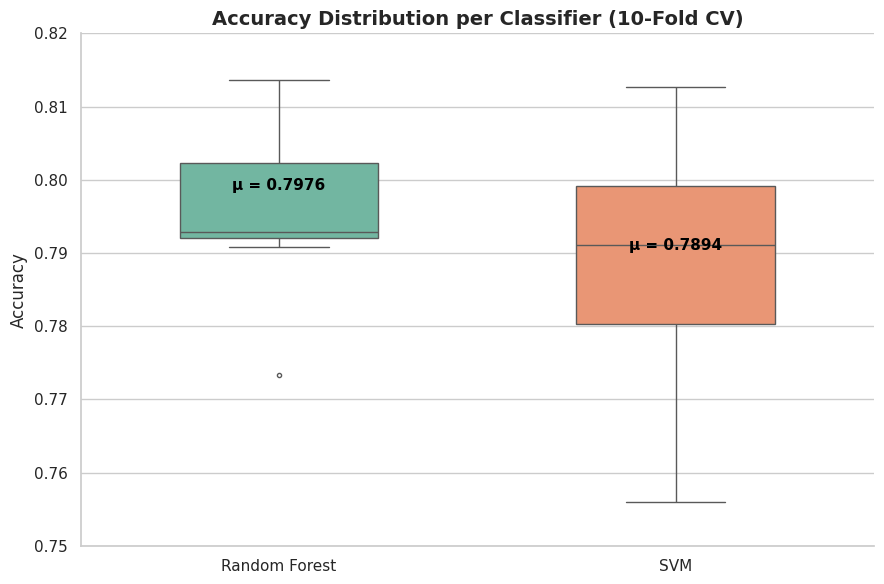


Total execution time: 358.88 seconds


In [ ]:
if __name__ == '__main__':
    """
    Main execution block:
    - Instantiates TitanicClassifierEvaluator with the dataset path.
    - Loads data and prepares preprocessing pipelines.
    - Evaluates Random Forest and SVM classifiers with hyperparameter tuning.
    - Plots boxplot comparison of cross-validation accuracies.
    - Prints total execution time.
    """
    start_time = time.time()

    path = 'PCC142---Data-Mining/spaceship_titanic/data.zip'
    evaluator = TitanicClassifierEvaluator(zip_path=path)

    evaluator.load_data()
    evaluator.prepare_pipeline()

    evaluator.evaluate_classifier(
        'Random Forest',
        RandomForestClassifier(random_state=42),
        {
            'clf__n_estimators': [50, 100],
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5]
        }
    )

    evaluator.evaluate_classifier(
        'SVM',
        SVC(random_state=42),
        {
            'clf__C': [0.1, 1, 10],
            'clf__kernel': ['rbf', 'linear'],
            'clf__gamma': ['scale', 'auto']
        }
    )

    evaluator.plot_boxplot_results()

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTotal execution time: {total_time:.2f} seconds")

### Random Forest

* **Best params:** `max_depth=10`, `min_samples_split=2`, `n_estimators=100`
  Isso indica uma árvore relativamente rasa (max\_depth=10), o que ajuda a evitar overfitting, e uma quantidade razoável de estimadores (100 árvores).
* **Mean Accuracy:** \~79.8%
* **Std Deviation:** \~1.4%
  A precisão média próxima de 80% é boa, e o desvio padrão pequeno indica que a validação cruzada foi estável.

### SVM

* **Best params:** `C=10`, `gamma='auto'`, `kernel='rbf'`
  Um C maior indica que o modelo está tentando ajustar os dados mais rigorosamente (menor regularização), com kernel RBF para capturar relações não lineares.
* **Mean Accuracy:** \~78.9%
* **Std Deviation:** \~1.6%
  Performance um pouco menor que a RF, mas próxima. Desvio padrão similar.

---

### Interpretação geral

* Ambos os modelos tiveram uma performance próxima, com Random Forest ligeiramente melhor.
* Desvios padrão baixos indicam que o modelo é consistente entre as folds.
